In [ ]:
!pip install -q datasets

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
import re
from wordcloud import WordCloud

In this notebook we will analyze the datasets we will use for training. We will use a reward model to analyze and reduce the number of samples. While reducing the samples we will select "better" samples using the reward model.

In [ ]:
import torch

from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load model and tokenizer
device = "cuda:0"
model_name = "Skywork/Skywork-Reward-Llama-3.1-8B-v0.2"
rm = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map=device,
    #attn_implementation="flash_attention_2",
    num_labels=1,
)
rm_tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset

dataset = load_dataset('json', data_files={"xlam_function_calling_60k.json"}, split = "train")

Generating train split: 0 examples [00:00, ? examples/s]

Lets check the token lenght of the samples

In [ ]:
token_len_list = []
for row in tqdm(dataset):
  query = row["query"]
  tool = row["tools"]
  answer = row["answers"]
  prompt = "Make an approprite function call according to user query:" + query + " Tools to use: " + tool

  conv = [{"role": "user", "content": prompt}, {"role": "assistant", "content": answer}]
  conv_tokenized = rm_tokenizer.apply_chat_template(conv, tokenize=True, return_tensors="pt").to(device)
  token_len_list.append(len(conv_tokenized[0]))

100%|██████████| 60000/60000 [01:29<00:00, 671.20it/s]


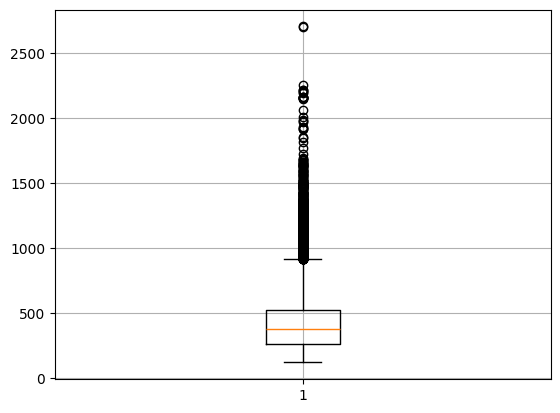

In [ ]:
plt.boxplot(token_len_list)
plt.grid()
plt.show()

In [ ]:
score = 0
data_list = []

for i,row in enumerate(tqdm(dataset)):
    query = row["query"]
    tool = row["tools"]
    answer = row["answers"]
    """
    We add the following instruction to let the reward model understand this is a function calling task (try getting rewards without it!)
    If you don't add the following instruction the rewards will highly decrease
    """
    prompt = "Make an approprite function call according to user query:" + query + " Tools to use: " + tool

    conv = [{"role": "user", "content": prompt}, {"role": "assistant", "content": answer}]
    conv_tokenized = rm_tokenizer.apply_chat_template(conv, tokenize=True, return_tensors="pt").to(device)

    # Get the reward scores
    with torch.no_grad():
        score = rm(conv_tokenized).logits[0][0].item()
        data_list.append([prompt,answer,score,len(conv_tokenized[0])])

100%|██████████| 60000/60000 [49:40<00:00, 20.13it/s]


In [ ]:
df.to_csv("out.csv") #Lets save our output

In [ ]:
df = pd.DataFrame(data_list)

Reward model may give higher score to complex answers. We would expect complex answers to be longer. So lets look at the correlation between token lenght and reward score. As you can see there is no correlation between token size and reward. So lets dive deeper into reward investigation.

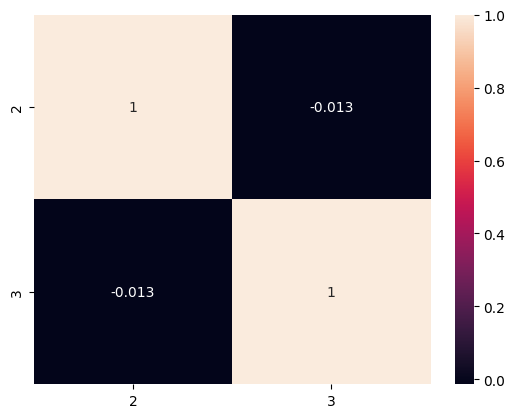

In [ ]:
correlation = df[["2","3"]].corr()
sns.heatmap(correlation,annot=True)
plt.show()

Now using pretty print lets print some samples with highest rewards.

In [ ]:
pprint.pp(df.loc[df["2"].nlargest(10).index]["0"].values[0])

("Make an approprite function call according to user query:I'm trying to get a "
 "specific number of products from the catalog, let's say 15, but I don't want "
 'to start from the beginning. I want to skip the first 200 products. Can you '
 'help me with that? Tools to use: [{"name": "get_products", "description": '
 '"Fetches a list of products from an external API with optional query '
 'parameters for limiting and skipping items in the response.", "parameters": '
 '{"limit": {"description": "The number of products to return.", "type": '
 '"int", "default": ""}, "skip": {"description": "The number of products to '
 'skip in the response.", "type": "int", "default": ""}}}]')


In [ ]:
df.loc[df["2"].nlargest(10).index]["1"].values[0]

'[{"name": "get_products", "arguments": {"limit": 15, "skip": 200}}]'

Now lets print the samples with lowest reward scores.

In [ ]:
pprint.pp(df.loc[df["2"].nsmallest(100).index]["0"].values[0])

('Make an approprite function call according to user query:Fetch the NEO-90 '
 'questionnaire using a custom RapidAPI key, but the key is invalid, and an '
 'error occurs. Return the error message. Tools to use: [{"name": '
 '"questionnaire_sentino", "description": "Fetches a questionnaire from the '
 'Sentino API based on the NEO-90 inventory.", "parameters": {"content_type": '
 '{"description": "The MIME type of the content being requested. Default is '
 '\'application/json\'.", "type": "str", "default": "application/json"}}}]')


In [ ]:
df.loc[df["2"].nsmallest(10).index]["1"].values[8]

'[{"name": "get_from_eztv", "arguments": {"searchtopic": "quantum physics"}}]'

The following instruction asks for a fake credit card information. It is expected for an LLM to reject answering this instruction which leads to low reward score.

In [ ]:
pprint.pp(df.loc[df["2"].nsmallest(100).index]["0"].values[1])

('Make an approprite function call according to user query:I need fake credit '
 'card information for ID 67890, can you provide that? Tools to use: [{"name": '
 '"random_credit_card_by_id", "description": "Retrieve fake credit card '
 'details by ID using the RapidAPI service.", "parameters": {"is_id": '
 '{"description": "The ID used to retrieve the fake credit card details.", '
 '"type": "int", "default": "1"}}}]')


This instruction is related to betting. The instruction also asks for and API key which might also lead to low reward score

In [ ]:
pprint.pp(df.loc[df["2"].nsmallest(100).index]["0"].values[3])

('Make an approprite function call according to user query:You are a data '
 'scientist and you want to fetch data from the oldsort endpoint using a '
 "custom RapidAPI key. The key is 'your_custom_key'. How can you use the "
 "'oldsort' function from the 'betsports' module to achieve this? Tools to "
 'use: [{"name": "oldsort", "description": "Fetches and sorts data from the '
 'oldsort endpoint using the given RapidAPI host and key.", "parameters": '
 '{"host": {"description": "The host to be used in the request header. '
 'Defaults to \'www.mozzartbet.com.co\'.", "type": "str", "default": '
 '"www.mozzartbet.com.co"}, "referer": {"description": "The referer to be used '
 'in the request header. Defaults to \'https://www.mozzartbet.com.co/es\'.", '
 '"type": "str", "default": "https://www.mozzartbet.com.co/es"}}}]')


In [ ]:
pprint.pp(df.loc[df["2"].nsmallest(100).index]["0"].values[7])

('Make an approprite function call according to user query:Please help me get '
 'the credit card details for ID 98765. Tools to use: [{"name": '
 '"random_credit_card_by_id", "description": "Retrieve fake credit card '
 'details by ID using the RapidAPI service.", "parameters": {"is_id": '
 '{"description": "The ID used to retrieve the fake credit card details.", '
 '"type": "int", "default": "1"}}}]')


We also have umm some "interesting" function calls. 🤐

In [ ]:
pprint.pp(df.loc[df["2"].nsmallest(100).index]["0"].values[36])

('Make an approprite function call according to user query:List pornstars with '
 'a cup size of D or larger and a waist size below 65 cm. Tools to use: '
 '[{"name": "listpornstars", "description": "Fetch a list of pornstars based '
 'on various filtering criteria.", "parameters": {"max_rank": {"description": '
 '"Maximum rank of the pornstar.", "type": "str, optional", "default": ""}, '
 '"min_rank": {"description": "Minimum rank of the pornstar.", "type": "str, '
 'optional", "default": ""}, "max_waist": {"description": "Maximum waist '
 'measurement of the pornstar.", "type": "str, optional", "default": ""}, '
 '"max_cup_size": {"description": "Maximum cup size of the pornstar.", "type": '
 '"str, optional", "default": ""}, "min_cup_size": {"description": "Minimum '
 'cup size of the pornstar.", "type": "str, optional", "default": ""}, '
 '"min_weight": {"description": "Minimum weight of the pornstar.", "type": '
 '"str, optional", "default": ""}, "max_weight": {"description": "Max

You can see the reward score distribution below

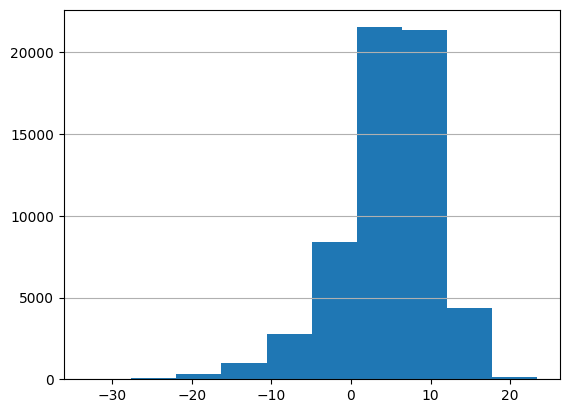

In [ ]:
plt.hist(df["2"])
plt.grid(axis="y")

Lets generate a word cloude to see most recurring words in the instructions

In [ ]:
zero_df = df[df["2"]<0]["0"]

word_cloud_list = []
for i in tqdm(range(len(zero_df))):
  text = zero_df.iloc[i]
  start_pos = text.find("query:") + len("query:")
  end_pos = text.find("Tools to use")
  if start_pos != -1 and end_pos != -1:
    extracted_text = text[start_pos:end_pos].strip()
    word_cloud_list.append(extracted_text)
  else:
    continue

100%|██████████| 10918/10918 [00:00<00:00, 188295.28it/s]


In [ ]:
word_cloud_text = " ".join(word_cloud_list)

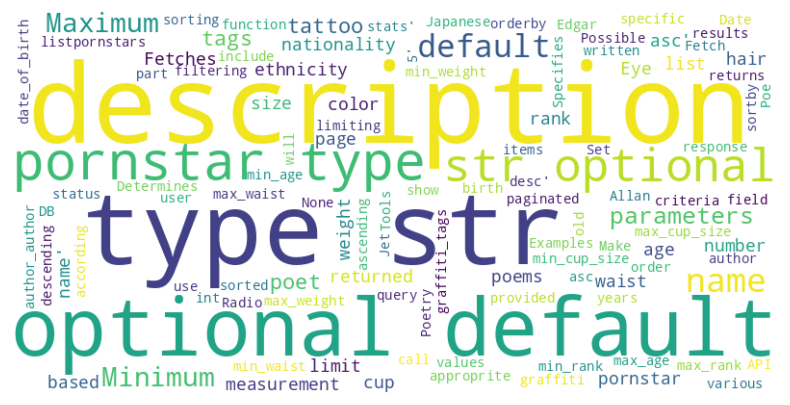

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off the axis
plt.show()

Altough most of these are expected there are some "interesting" words. Lets remove some expected words to see the others better.

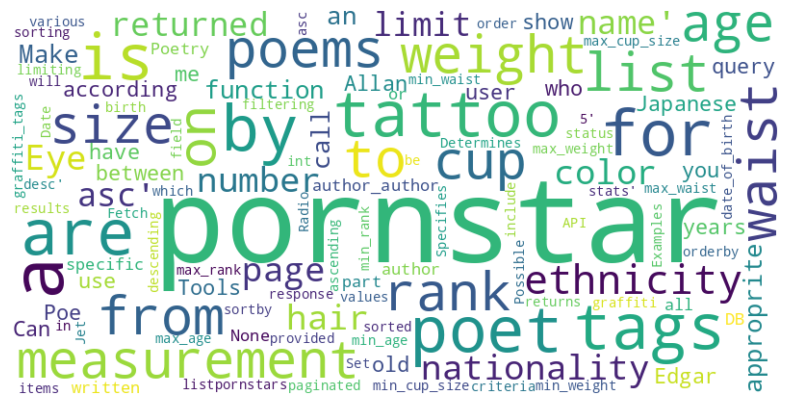

In [ ]:
exclude_words = ["description", "type", "default", "str","Minimum","Maximum","Fetches","based","the","of","and","optional","parameters","name"]
wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=exclude_words).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now lets alpaca dataset. We will also use this dataset so our LLM doesn't forget following instructions. If we train only on function calling out model will forget instruction following and try answering everything using function calling.

In [ ]:
alpaca_dataset = load_dataset("yahma/alpaca-cleaned", split = "train")

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

alpaca_data_cleaned.json:   0%|          | 0.00/44.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]

Again lets check token size distribution

In [ ]:
token_len_list = []
for row in tqdm(alpaca_dataset):
  instruction = row["instruction"]
  input = row["input"]
  output = row["output"]
  if input == "":
    prompt = instruction
  else:
    prompt = instruction + " " + input

  conv = [{"role": "user", "content": prompt}, {"role": "assistant", "content": output}]
  conv_tokenized = rm_tokenizer.apply_chat_template(conv, tokenize=True, return_tensors="pt").to(device)
  token_len_list.append(len(conv_tokenized[0]))

100%|██████████| 51760/51760 [00:56<00:00, 918.88it/s]


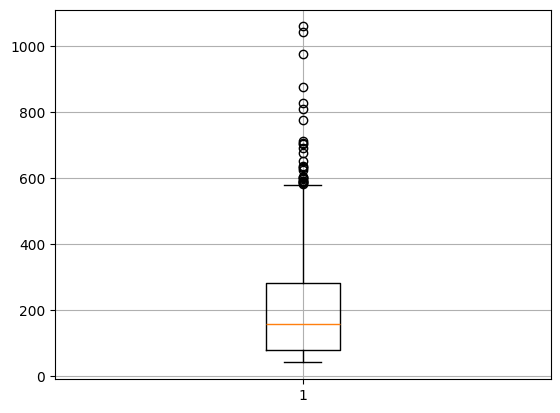

In [ ]:
plt.boxplot(token_len_list)
plt.grid()
plt.show()

In [ ]:
score = 0
data_list = []

for row in tqdm(alpaca_dataset):
  instruction = row["instruction"]
  input = row["input"]
  output = row["output"]
  if input == "":
    prompt = instruction
  else:
    prompt = instruction + " " + input

  conv = [{"role": "user", "content": prompt}, {"role": "assistant", "content": output}]
  conv_tokenized = rm_tokenizer.apply_chat_template(conv, tokenize=True, return_tensors="pt").to(device)
  with torch.no_grad():
    score = rm(conv_tokenized).logits[0][0].item()
    data_list.append([prompt,output,score,len(conv_tokenized[0])])

100%|██████████| 51760/51760 [37:23<00:00, 23.07it/s]


In [ ]:
df = pd.DataFrame(data_list)

In [ ]:
df.to_csv("out_alpaca.csv")

Again there is no correlation between token size and reward score

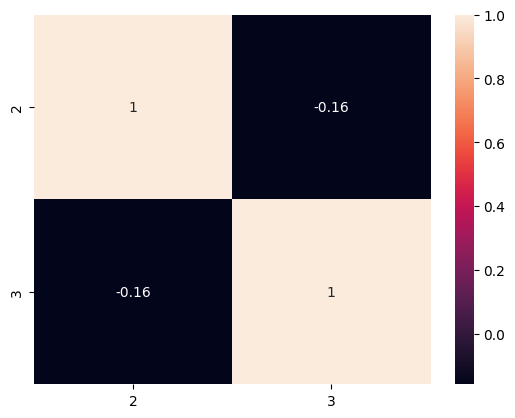

In [ ]:
correlation = df[[2,3]].corr() 
sns.heatmap(correlation,annot=True)
plt.show()

In [ ]:
pprint.pp(df.loc[df[2].nlargest(10).index][0].values[0])

('Given a non-empty array of integers nums, every element appears twice except '
 'for one. Find that single one.\n'
 'You must implement a solution with a linear runtime complexity and use only '
 'constant extra space.')


You can see that in the sample below the answer is unrelated to the instruction hence the reward score is low.

In [ ]:
pprint.pp(df.loc[df[2].nsmallest(10).index][0].values[2])

("Use the following context to answer the question at the end. If you don't "
 "know the answer, just say that you don't know, don't try to make up an "
 'answer. Brazilian Jiu Jitsu is a predominantly ground-based martial art, '
 'using the principals of leverage, angles, pressure and timing, as well as '
 'knowledge of the human anatomy, in order to achieve a non-violent submission '
 'of one’s opponent. Unlike other martial arts that focus on strikes and/or '
 'kicks, jiu jitsu focuses on close-contact "grappling" holds and techniques, '
 'and the application of chokes and joint-manipulations.\n'
 'Question: What principles apply to jiu jitsu?')


In [ ]:
pprint.pp(df.loc[df[2].nsmallest(10).index][1].values[2])

('A circular logo with a green background resembling a globe with an abstract '
 'image of two interlocked hands in the center, suggestive of global '
 'partnership.')


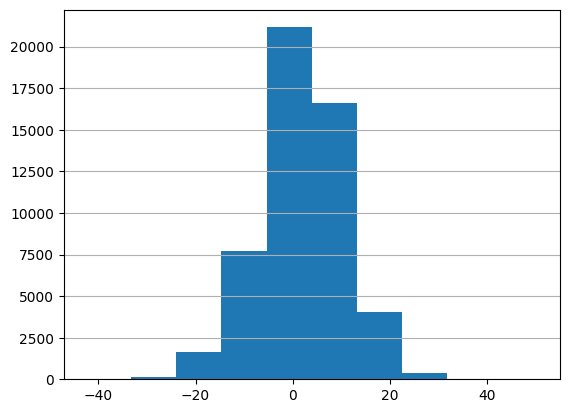

In [ ]:
plt.hist(df[2])
plt.grid(axis="y")